In [1]:
!pip install ipympl
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, HBox, VBox, Layout
from IPython.display import display
from google.colab import output
output.enable_custom_widget_manager()

In [2]:
img_h, img_w = 480, 640

In [3]:
keys = [(335,135),(570,200),(500,400),(320,330)]
ofs = (-290,-20)
keys0 = [ (p[0]+ofs[0],p[1]+ofs[1]) for p in keys ]
keys = np.array(keys0, np.float32)
keysavg = np.average(keys,axis=0)
keysstd = np.std(keys,axis=0)
keys_norm = (keys - keysavg)/keysstd

In [4]:
values = [(50,150),(250,150),(250,350),(50,350)]
ofs = (300,0)
values0 = [ (p[0]+ofs[0],p[1]+ofs[1]) for p in values ]
values = np.array(values0, np.float32)
valuesavg = np.average(values,axis=0)
valuesstd = np.std(values,axis=0)
values_norm = (values - valuesavg)/valuesstd

In [5]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [6]:
def project(x, y, d):  # via attention
    q = (np.array([x, y], np.float32) - keysavg) / keysstd
    c = softmax(q @ keys_norm.T / d)
    p = c @ values_norm
    return tuple(np.asarray(p * valuesstd + valuesavg, np.int32))

In [7]:
# Distance scaling range
dmax = np.sqrt(2)
dmin = 1/4

interactive(children=(FloatSlider(value=1.0, description='Scaling:', max=2.0, min=0.25, step=0.05), Output()),…

<function __main__.update_plot(scale)>

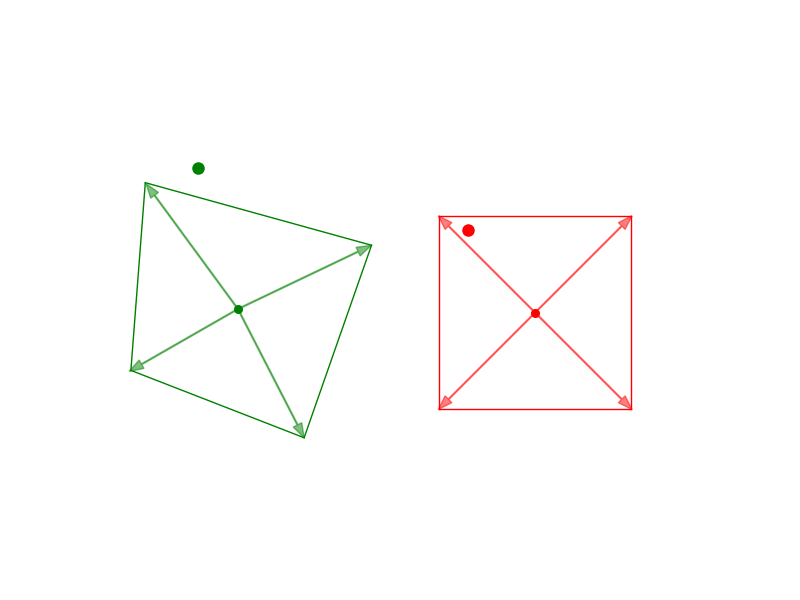

In [13]:
# Interactive plot
fig, ax = plt.subplots(figsize=(8,6))
fig.canvas.header_visible = False
ax.set_xlim(0, img_w)
ax.set_ylim(img_h, 0)
ax.set_aspect('equal')
ax.axis('off')

def draw_base():
    for i in range(4):
        p1, p2 = values0[i], values0[(i+1)%4]
        q1, q2 = keys0[i], keys0[(i+1)%4]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', linewidth=1)
        ax.plot([q1[0], q2[0]], [q1[1], q2[1]], 'g-', linewidth=1)
    ax.scatter(*valuesavg, color='r', s=30)
    ax.scatter(*keysavg, color='g', s=30)
    for i in range(4):
        ax.arrow(valuesavg[0], valuesavg[1],
                 (values0[i][0]-valuesavg[0])*0.9,
                 (values0[i][1]-valuesavg[1])*0.9,
                 color='r', width=1, head_width=10, alpha=0.5)
        ax.arrow(keysavg[0], keysavg[1],
                 (keys0[i][0]-keysavg[0])*0.9,
                 (keys0[i][1]-keysavg[1])*0.9,
                 color='g', width=1, head_width=10, alpha=0.5)

draw_base()

flow = False
x, y = 100, 100
green_point, = ax.plot([x], [y], 'go', markersize=8)
red_point, = ax.plot([], [], 'ro', markersize=8)

def update_plot(scale):
    x2, y2 = project(x, y, scale)
    green_point.set_data([x], [y])
    red_point.set_data([x2], [y2])
    fig.canvas.draw_idle()

def onmove(event):
    global x, y
    if event.inaxes != ax:
        return
    x, y = event.xdata, event.ydata
    update_plot(scale_slider.value)

def onclick(event):
    global flow
    flow = not flow
    if flow:
      onmove(event)

fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('motion_notify_event', onmove)

scale_slider = FloatSlider(value=1.0, min=0.25, max=2.0, step=0.05, orientation='horizontal', description='Scaling:')
gui = HBox([ fig.canvas, VBox([scale_slider], layout=Layout(align_items='center',justify_content='center'))])
display(gui)
interact(update_plot, scale=scale_slider)